In [1]:
import sys
sys.path.append('../../')
from src.scoring_functions import *
from src.load_data import *

In [16]:
# files = glob.glob(f'../../data/pre-covid/{period}*[0-9][0-9][0-9][0-9].csv') 

In [17]:
files = glob.glob(f'../../data/pre-covid/*.csv') 

In [18]:
files

['../../data/pre-covid/cv-test-tft-2019.csv',
 '../../data/pre-covid/cv-test-tsmixer-2019.csv']

In [23]:
files[-1].split('/')[-1].split('-', 1)[-1][:-4]

'test-tsmixer-2019'

In [26]:
files[-1].split('/')[-1].split('-')[2]

'tsmixer'

In [20]:
files[-1][-8:-4]

'2019'

In [27]:
dfs = []
for file in files:
    df_temp = pd.read_csv(file)
    df_temp['model'] = file.split('/')[-1].split('-')[2]
    df_temp['test_year'] = file[-8:-4]
    dfs.append(df_temp)
df = pd.concat(dfs)

In [28]:
df

,location,age_group,forecast_date,target_end_date,horizon,type,quantile,value,model,test_year
0,DE,00+,2019-10-03,2019-10-06,1,quantile,0.025,5603.800,tft,2019
1,DE,00+,2019-10-03,2019-10-13,2,quantile,0.025,5650.525,tft,2019
2,DE,00+,2019-10-03,2019-10-20,3,quantile,0.025,6043.500,tft,2019
3,DE,00+,2019-10-03,2019-10-27,4,quantile,0.025,6196.600,tft,2019
4,DE,00-04,2019-10-03,2019-10-06,1,quantile,0.025,678.850,tft,2019
...,...,...,...,...,...,...,...,...,...,...
6855,DE,60-79,2020-09-03,2020-09-27,4,quantile,0.975,2358.325,tsmixer,2019
6856,DE,80+,2020-09-03,2020-09-06,1,quantile,0.975,2495.000,tsmixer,2019
6857,DE,80+,2020-09-03,2020-09-13,2,quantile,0.975,2601.100,tsmixer,2019
6858,DE,80+,2020-09-03,2020-09-20,3,quantile,0.975,2568.125,tsmixer,2019


In [2]:
def add_truth(df, source='icosari', disease='sari'):
    df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/latest_data-{source}-{disease}.csv')
    df_truth = df_truth.rename(columns={'value': 'truth'})

    df = df.merge(df_truth, how='left', 
                   left_on=['location', 'age_group', 'target_end_date'], 
                   right_on=['location', 'age_group', 'date'])
    return df

In [3]:
def load_predictions(source='icosari', disease='sari', period='test', include_median=True, include_truth=True):
    files = glob.glob(f'../../data/pre-covid/*.csv') 
    
    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file.split('/')[-1].split('-')[2]
        df_temp['test_year'] = file[-8:-4]
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    if include_median:
        df = add_median(df)
    if include_truth:
        df = add_truth(df, source, disease)

    return df

In [4]:
source='icosari'
disease='sari'

In [5]:
df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/latest_data-{source}-{disease}.csv')

In [6]:
df = load_predictions('icosari', 'sari')

In [7]:
df

,location,age_group,forecast_date,target_end_date,horizon,type,quantile,value,model,test_year,date,year,week,truth
0,DE,00+,2019-10-03,2019-10-06,1,quantile,0.025,5528.900,tft,2019,2019-10-06,2019,40,7399
1,DE,00+,2019-10-03,2019-10-13,2,quantile,0.025,5693.350,tft,2019,2019-10-13,2019,41,8646
2,DE,00+,2019-10-03,2019-10-20,3,quantile,0.025,5971.925,tft,2019,2019-10-20,2019,42,8729
3,DE,00+,2019-10-03,2019-10-27,4,quantile,0.025,6026.575,tft,2019,2019-10-27,2019,43,8563
4,DE,00-04,2019-10-03,2019-10-06,1,quantile,0.025,686.925,tft,2019,2019-10-06,2019,40,1119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16459,DE,60-79,2020-09-03,2020-09-27,4,median,0.500,1693.000,tsmixer,2019,2020-09-27,2020,39,2087
16460,DE,80+,2020-09-03,2020-09-06,1,median,0.500,1680.500,tsmixer,2019,2020-09-06,2020,36,1465
16461,DE,80+,2020-09-03,2020-09-13,2,median,0.500,1789.000,tsmixer,2019,2020-09-13,2020,37,1786
16462,DE,80+,2020-09-03,2020-09-20,3,median,0.500,1735.500,tsmixer,2019,2020-09-20,2020,38,1732


In [8]:
df.model.unique()

array(['tft', 'tsmixer'], dtype=object)

#### National level

In [10]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,tsmixer,326.530065,183.408622,349.657296,859.595983,0.408163,0.969388
1,tft,269.834006,712.996633,85.410204,1068.240843,0.255102,0.755102


#### Age groups

In [11]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,tsmixer,64.909618,57.582151,76.999753,199.491523,0.414116,0.874150
1,tft,59.689893,161.807543,29.867755,251.365190,0.362245,0.784864


# Plots

In [12]:
from plotnine import ggplot, aes, geom_bar, geom_label, scale_alpha_manual, labs, coord_flip, theme_bw, theme, geom_line, scale_alpha_discrete, guide_legend

In [13]:
df = evaluate_models(df, 'national')

In [14]:
scores = pd.melt(df, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

In [15]:
df

,model,spread,overprediction,underprediction,wis,c50,c95
0,tsmixer,326.530065,183.408622,349.657296,859.595983,0.408163,0.969388
1,tft,269.834006,712.996633,85.410204,1068.240843,0.255102,0.755102


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


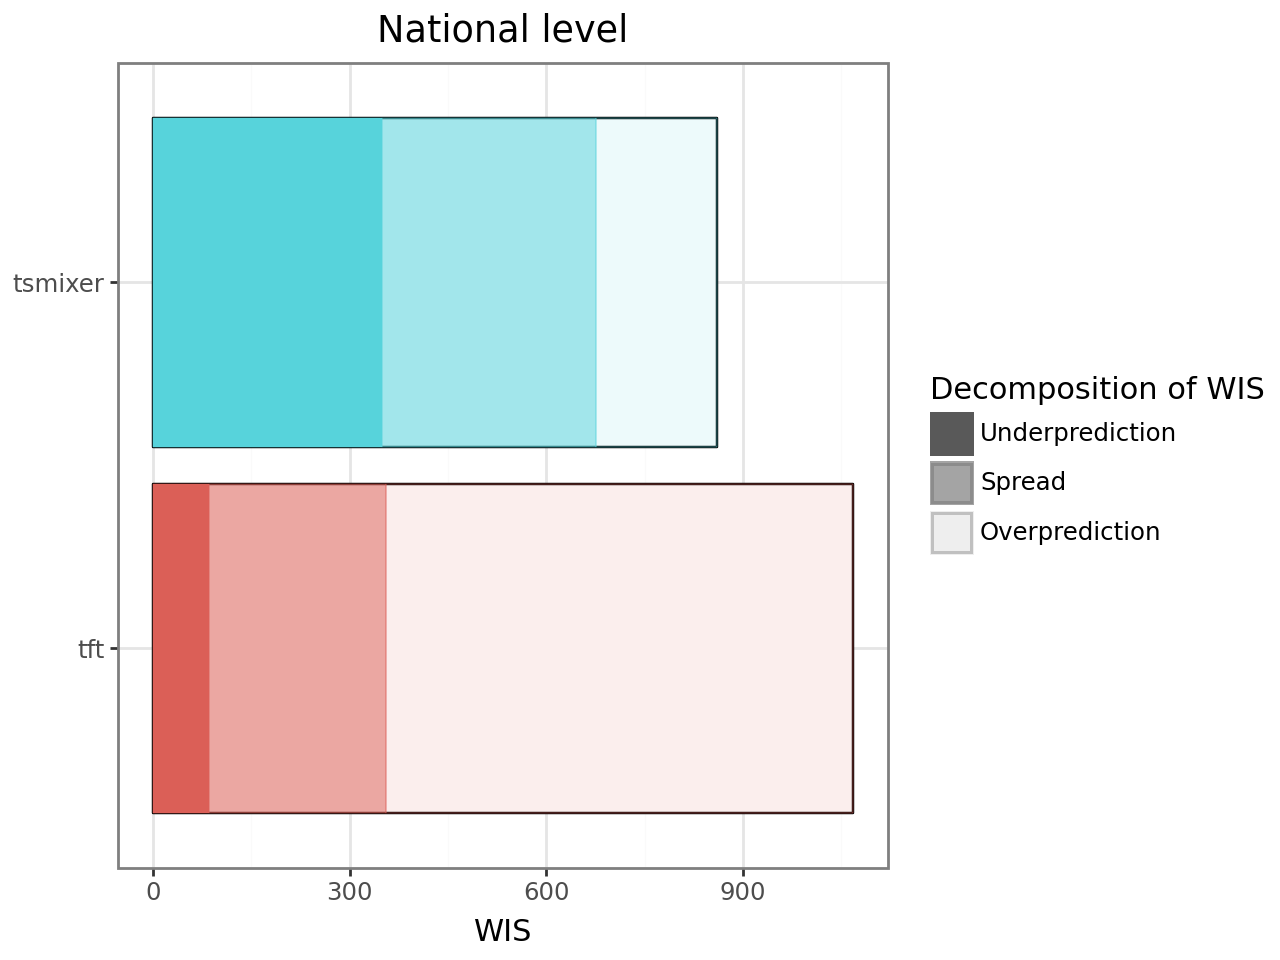

In [16]:
(ggplot()
    + geom_bar(df, aes(x='model', y='wis'), fill='white', color='black', stat='identity')
    + geom_bar(scores, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.1, stat='identity', 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS", title="National level")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='right')
   )